# EXAM - GROUP 5

## Data preparation

<Axes: xlabel='timestamp'>

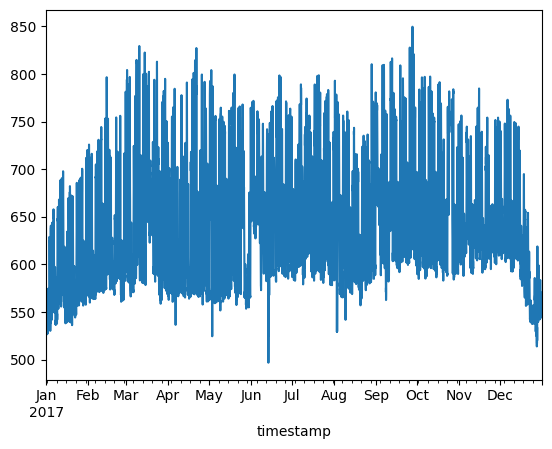

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import calmap
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, Normalize
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler

building_df_train = pd.read_csv("data/building_5_weather_1_train.csv", parse_dates=['timestamp'])
weather_df = pd.read_csv("data/weather_1.csv", parse_dates=['timestamp'])

building_df_test = pd.read_csv("data/building_5_weather_1_test.csv", parse_dates=['timestamp'])

building_df = pd.concat([building_df_test,building_df_train])

building_df.drop_duplicates(inplace=True)
building_df.set_index('timestamp',inplace=True)
weather_df.drop_duplicates(inplace=True)
weather_df.set_index('timestamp',inplace=True)

building_df.sort_index(inplace=True)

data = building_df.join(weather_df,how='left',on='timestamp') # we chose the left join because there are some missing dates in weather.csv

data['hour'] = data.index.hour
data['date'] = data.index.date
data['dayofweek'] = data.index.dayofweek
data['month'] = data.index.month

data['power'].plot()



In [2]:
print(f'The dataset shape is:', data.shape)
print(f'The training dataset covers a period between', min(data.index), 'and', max(data.index))

The dataset shape is: (8760, 6)
The training dataset covers a period between 2017-01-01 00:00:00 and 2017-12-31 23:00:00


### Outliers

#### Z-score Outlier

timestamp
2017-03-10 14:00:00    829.4961
2017-09-27 14:00:00    849.7478
Name: power, dtype: float64


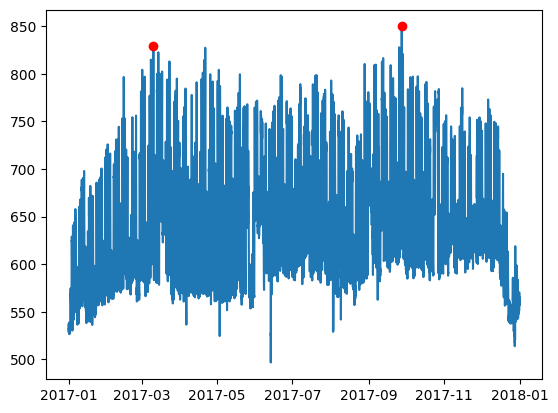

In [3]:
# calculate z-scores for each column
z_scores = (data['power'] - data['power'].mean()) / data['power'].std()

# define std limit (default 3)
std_limit = 3

# identify outliers as data points with z-score greater than std_limit or less than -std_limit
outliers_z_score = data['power'][(z_scores > std_limit) | (z_scores < -std_limit)]

print(outliers_z_score)

# plot column 'a' with outlier in red
plt.plot(data['power'])
plt.plot(outliers_z_score.index, data.loc[outliers_z_score.index, 'power'], 'ro')
plt.show()


#### Boxplot interquantile

timestamp
2017-03-10 14:00:00    829.4961
2017-03-14 14:00:00    822.6265
2017-04-21 14:00:00    827.3444
2017-09-25 14:00:00    827.8472
2017-09-26 14:00:00    819.3258
2017-09-27 14:00:00    849.7478
2017-09-27 15:00:00    828.7553
2017-09-28 13:00:00    818.0747
2017-09-28 14:00:00    820.8011
Name: power, dtype: float64


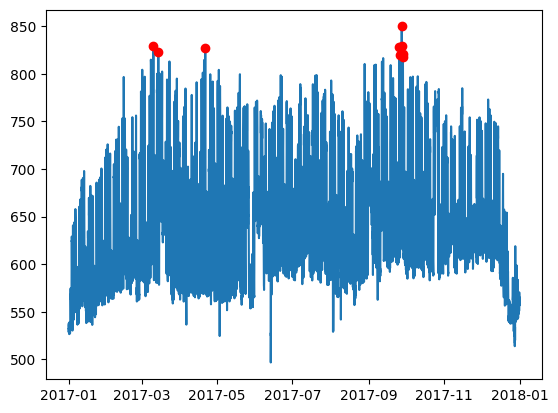

In [4]:
# evaluate 1st and 3rd quartile
Q1 = data['power'].quantile(0.25)
Q3 = data['power'].quantile(0.75)

# evaluate interquartile
IQR = Q3 - Q1

# define IQR limit (default 1.5)
IQR_limit = 1.5

# identify and highlight outliers
outliers_interquantile = data['power'][(data['power'] < Q1 - IQR_limit*IQR) | (data['power'] > Q3 + IQR_limit*IQR)]

print(outliers_interquantile)

plt.plot(data['power'])
plt.plot(outliers_interquantile.index, data.loc[outliers_interquantile.index, 'power'], 'ro')
plt.show()

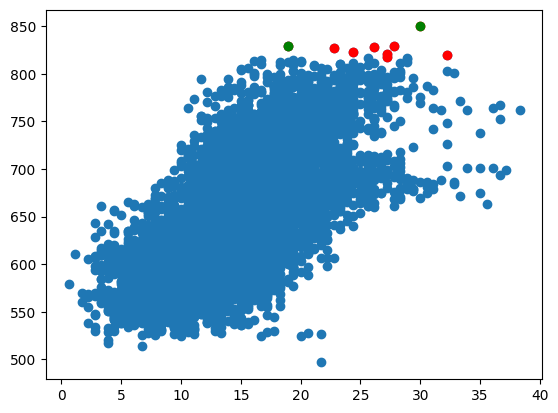

In [7]:
plt.scatter(data['airTemperature'],data['power'])
plt.scatter(data['airTemperature'].loc[outliers_interquantile.index],outliers_interquantile,c='red')
plt.scatter(data['airTemperature'].loc[outliers_z_score.index],outliers_z_score,c='green')
plt.show()

### Remove outliers

In [6]:
data.power.loc[outliers_z_score.index[1]] = np.nan  # we consider outlier only 27-09-2023

data.head()

C:\Users\itgiman10\AppData\Local\Temp\ipykernel_65944\3525068765.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.power.loc[outliers_z_score.index[1]] = np.nan  # we consider outlier only 27-09-2023


,power,airTemperature,hour,date,dayofweek,month
timestamp,,,,,,
2017-01-01 00:00:00,537.1756,8.3,0,2017-01-01,6,1
2017-01-01 01:00:00,528.6003,10.6,1,2017-01-01,6,1
2017-01-01 02:00:00,532.4253,11.1,2,2017-01-01,6,1
2017-01-01 03:00:00,535.8997,11.1,3,2017-01-01,6,1
2017-01-01 04:00:00,531.9250,10.6,4,2017-01-01,6,1


### Missing Value

In [8]:
print(f'The missing value for Power are:', data['power'].isna().sum())
print(f'The missing value for Temperature are:', data['airTemperature'].isna().sum())

The missing value for Power are: 41
The missing value for Temperature are: 1


In [28]:
seeNA = data[data['power'].isna()]
for n in range(1,seeNA.shape[0]):
    print(f'The distance beetween index',n, 'and', n-1, 'is', seeNA.index[n] - seeNA.index[n-1])

The distance beetween index 1 and 0 is 199 days 12:00:00
The distance beetween index 2 and 1 is 27 days 05:00:00
The distance beetween index 3 and 2 is 0 days 01:00:00
The distance beetween index 4 and 3 is 0 days 01:00:00
The distance beetween index 5 and 4 is 0 days 01:00:00
The distance beetween index 6 and 5 is 0 days 01:00:00
The distance beetween index 7 and 6 is 0 days 01:00:00
The distance beetween index 8 and 7 is 0 days 01:00:00
The distance beetween index 9 and 8 is 0 days 01:00:00
The distance beetween index 10 and 9 is 0 days 01:00:00
The distance beetween index 11 and 10 is 0 days 01:00:00
The distance beetween index 12 and 11 is 0 days 01:00:00
The distance beetween index 13 and 12 is 0 days 01:00:00
The distance beetween index 14 and 13 is 0 days 01:00:00
The distance beetween index 15 and 14 is 0 days 01:00:00
The distance beetween index 16 and 15 is 0 days 01:00:00
The distance beetween index 17 and 16 is 0 days 01:00:00
The distance beetween index 18 and 17 is 0 days

<Axes: xlabel='timestamp'>

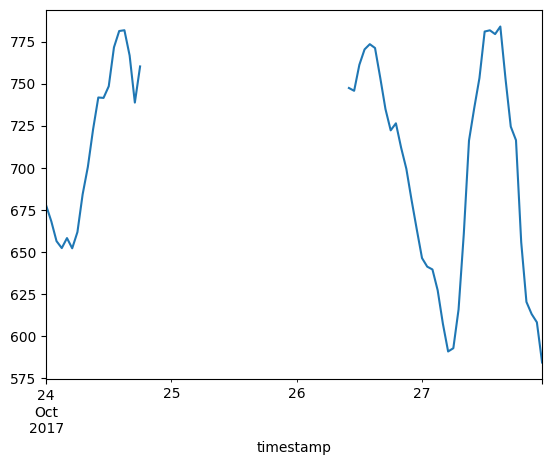

In [29]:
data[data['power'].isna()]
data["2017-10-24":"2017-10-27"]['power'].plot()

#### Interpolation with limit 1

<Axes: xlabel='timestamp'>

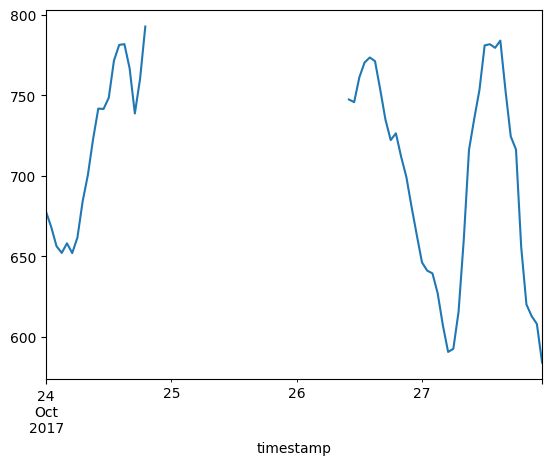

In [30]:
data['airTemperature'].interpolate('spline',limit=1,inplace=True,order=3)

data['power'].interpolate('spline',limit=1,inplace=True,order=3) # the interpolation with limit 3 creates outliers so we prefer 1
data[data['power'].isna()]
data["2017-10-24":"2017-10-27"]['power'].plot()

In [31]:
print(f'The missing value for Power, after interpolation, are:', data['power'].isna().sum())
print(f'The missing value for Temperature, after interpolation, are:', data['airTemperature'].isna().sum())

The missing value for Power, after interpolation, are: 38
The missing value for Temperature, after interpolation, are: 0


In [32]:
datesWithNa = np.unique(data.date[data['power'].isna()])
print(datesWithNa)

[datetime.date(2017, 10, 24) datetime.date(2017, 10, 25)
 datetime.date(2017, 10, 26)]


In [33]:
# we drop the entire day if it has some NA

data_withoutNA = data[ ~data['date'].isin(datesWithNa)]
#data_withoutNA = data.dropna(subset=['power'])
print(data_withoutNA)

                        power  airTemperature  hour        date  dayofweek  \
timestamp                                                                    
2017-01-01 00:00:00  537.1756             8.3     0  2017-01-01          6   
2017-01-01 01:00:00  528.6003            10.6     1  2017-01-01          6   
2017-01-01 02:00:00  532.4253            11.1     2  2017-01-01          6   
2017-01-01 03:00:00  535.8997            11.1     3  2017-01-01          6   
2017-01-01 04:00:00  531.9250            10.6     4  2017-01-01          6   
...                       ...             ...   ...         ...        ...   
2017-12-31 19:00:00  559.0000            11.1    19  2017-12-31          6   
2017-12-31 20:00:00  561.9500            11.1    20  2017-12-31          6   
2017-12-31 21:00:00  556.5753             9.4    21  2017-12-31          6   
2017-12-31 22:00:00  565.3997             9.4    22  2017-12-31          6   
2017-12-31 23:00:00  560.0506             8.9    23  2017-12-31 

### Data visualization

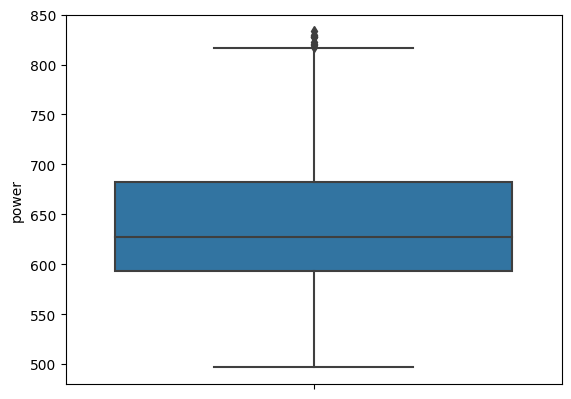

In [34]:
sns.boxplot(y="power", data=data)
plt.show()

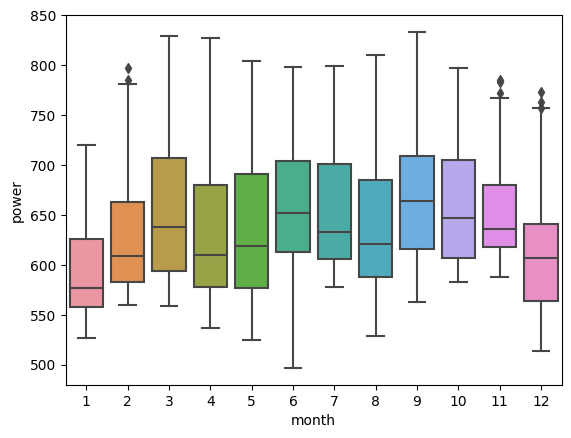

In [35]:
sns.boxplot(x='month', y="power", data=data)
plt.show()

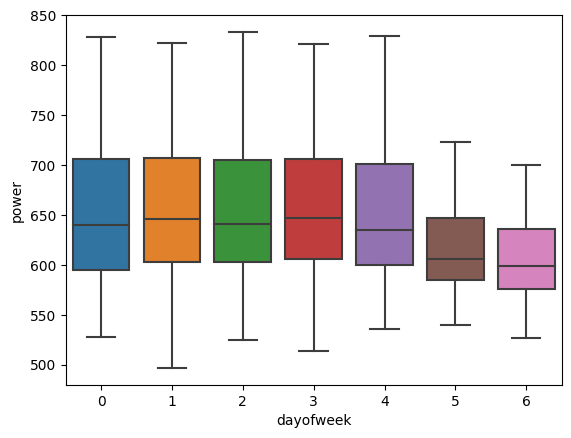

In [36]:
sns.boxplot(x='dayofweek', y="power", data=data)
plt.show()

c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


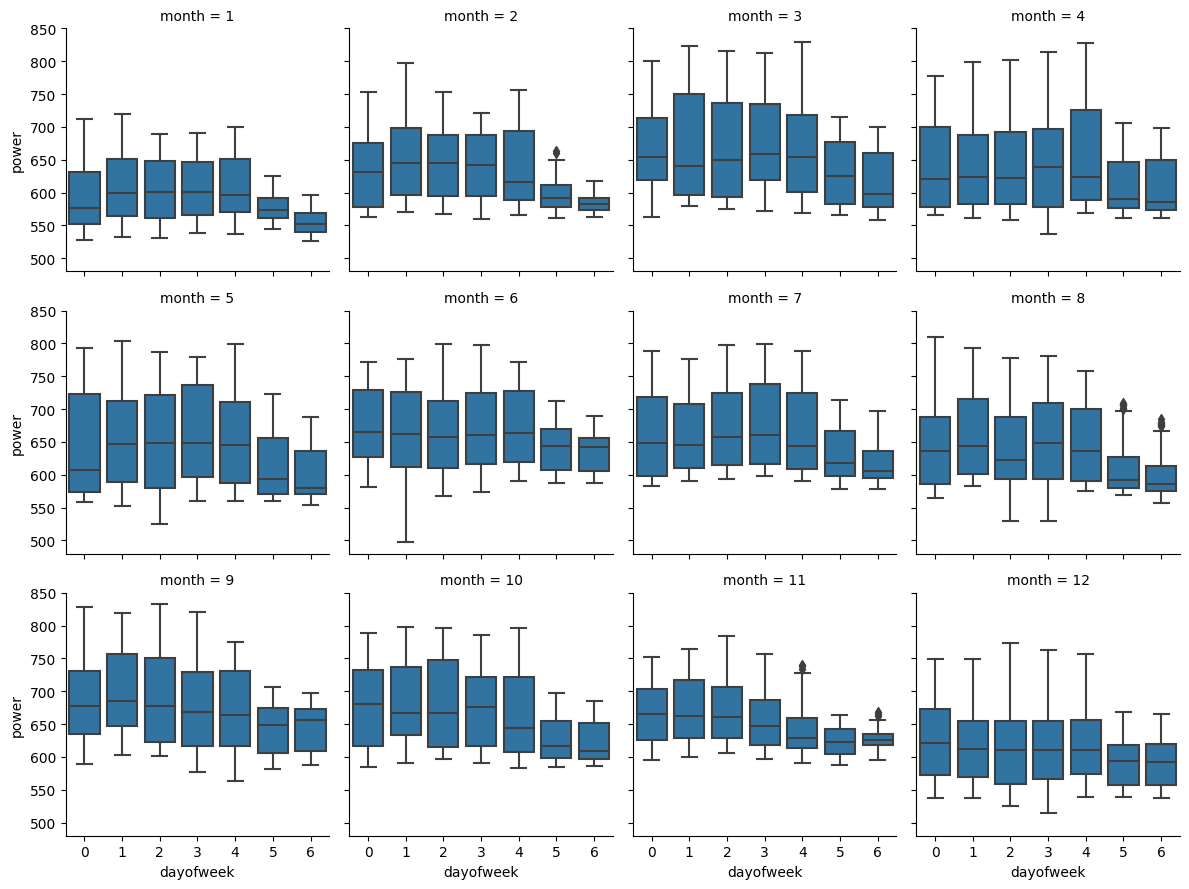

In [37]:
g = sns.FacetGrid(data, col="month", col_wrap=4)
g.map(sns.boxplot, "dayofweek", "power")
plt.show()

##  Load profiles characterization

In [42]:
print(f'The number of date duplicated is: ', data.index.duplicated().sum())

data_withoutNA_training = data_withoutNA['2017-01-01':'2017-10-31']

pv_data = data_withoutNA_training.pivot(index='date',columns='hour',values='power')


The number of date duplicated is:  0


Text(120.72222222222221, 0.5, 'Date')

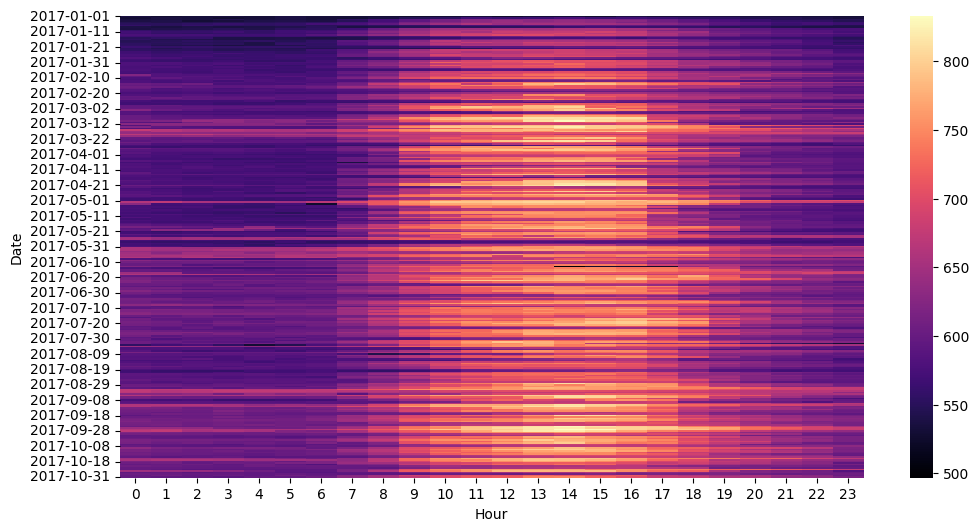

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(pv_data, cmap='magma', ax=ax)

# impostazione delle etichette degli assi
ax.set_xlabel('Hour')
ax.set_ylabel('Date')

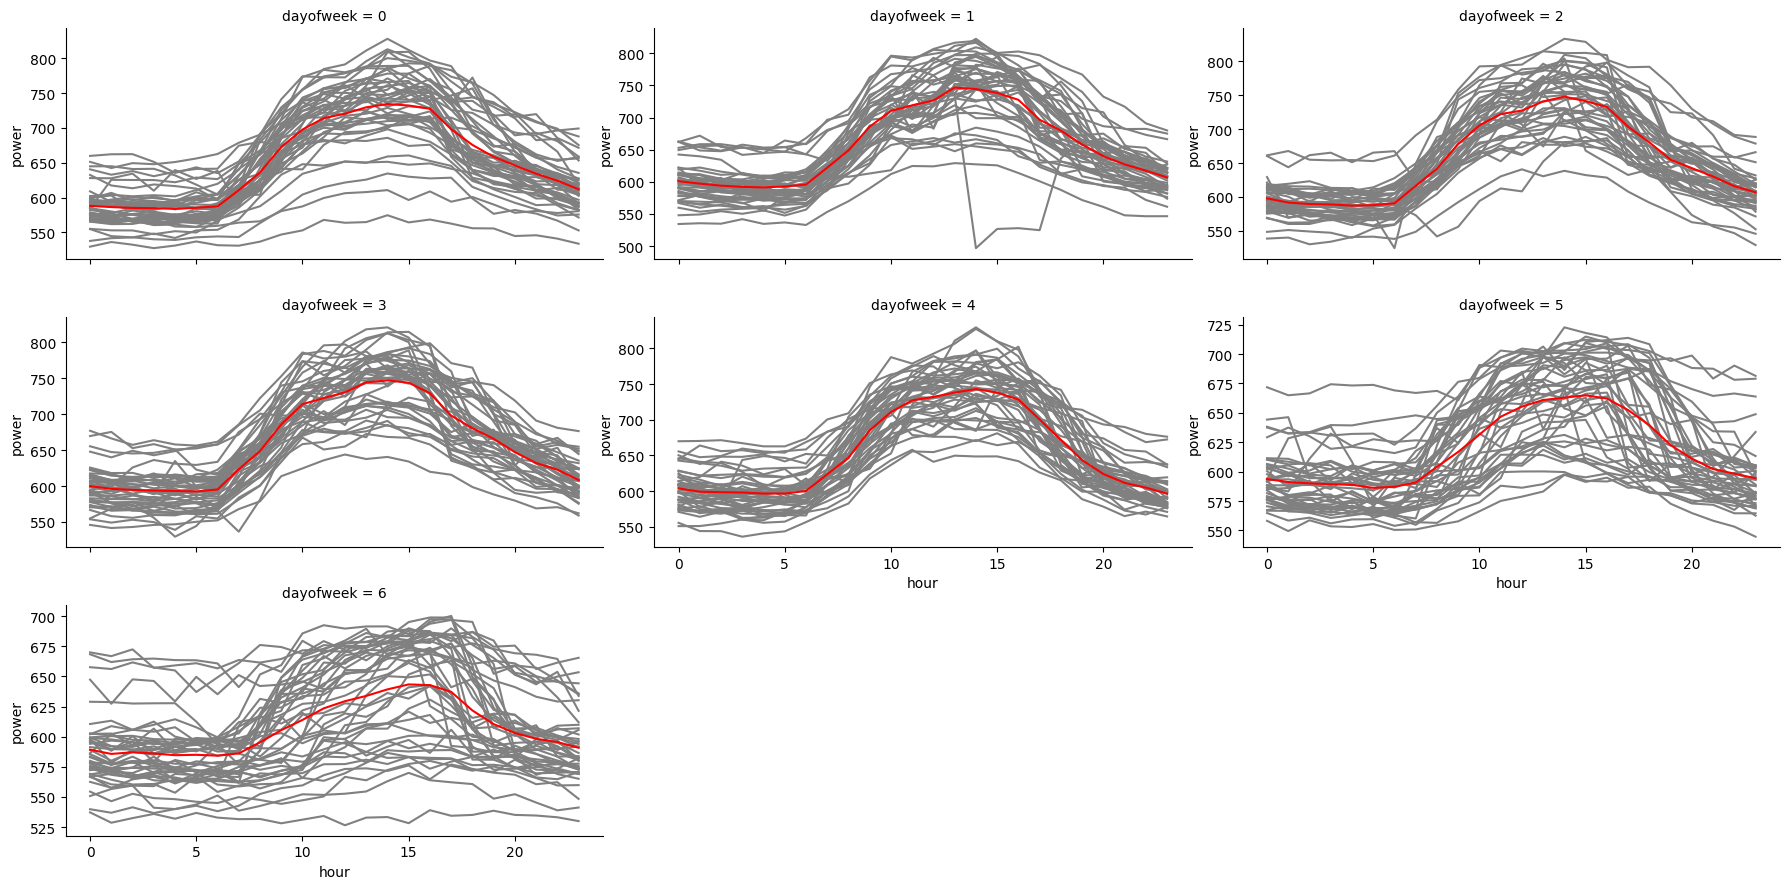

In [44]:
# creating a new DataFrame with the average power for each hour of the day and for each day of the week
data_mean = data_withoutNA_training.groupby(['dayofweek', 'hour'])['power'].mean().reset_index()

# generating load profiles
g = sns.FacetGrid(data=data_withoutNA_training, col='dayofweek', hue='date', col_wrap=3, height=3, aspect=2, sharey=False)
g.map(sns.lineplot, 'hour', 'power', color='gray')

# adding average values
for ax, day in zip(g.axes.flatten(), data_mean['dayofweek'].unique()):
    sns.lineplot(x='hour', y='power', data=data_mean[data_mean['dayofweek'] == day], color='r', ax=ax, label='Profilo medio', legend=False)

plt.show()

### Identification of the best cluster 
#### K-Means

In [90]:
# pv_data.isna().sum()
# pv_data.dropna(inplace= True)

In [45]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

k_range = [i for i in range(2,8)]
db_list = []
sh_list = []

for k in k_range:
  kmeans = KMeans(n_clusters=k,random_state=0).fit(pv_data)
  labels = kmeans.labels_
  sh_list.append(silhouette_score(pv_data, labels))
  db_list.append(davies_bouldin_score(pv_data, labels))

print(f"The best number of clusters according to Silhouette is {k_range[np.argmax(sh_list)]} with a score of {round(max(sh_list),2)}")
print(f"The best number of clusters according to DB Index is {k_range[np.argmin(db_list)]} with a score fo {round(min(db_list),2)}")

c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib

The best number of clusters according to Silhouette is 2 with a score of 0.43
The best number of clusters according to DB Index is 2 with a score fo 0.83


In [46]:
print(sh_list)
print(db_list)

[0.4251957679762042, 0.32044736438577753, 0.26994903715432483, 0.27818723673993834, 0.2722699765698595, 0.2635932508590554]
[0.8316838774577512, 1.066755102277152, 1.1415279661192295, 1.1808626691754385, 1.1466597556722624, 1.1980747646504608]


In [53]:
def plot_clustering_results(dataset, pivot_dataset):
    # creating a new DataFrame with the average power for each hour of the day and for each cluster
    centroids = dataset.groupby(['cluster', 'hour']).mean().reset_index()
    centroids.head()

    # generating load profiles
    g = sns.FacetGrid(data=dataset, col='cluster', hue='date', col_wrap=3, height=3, aspect=2, sharey=False)
    g.map(sns.lineplot, 'hour', 'power', color='gray')

    # adding average values
    i = 0
    for ax, cluster in zip(g.axes.flatten(), centroids['cluster'].unique()):
        sns.lineplot(x='hour', y='power', data=centroids[centroids['cluster'] == cluster], color='r', ax=ax, label='Profilo medio', legend=False)
        ax.set_ylim(bottom=0, top=dataset['power'].max())
        ax.set_xticks(range(0, 24))
        ax.grid(True, linestyle='--')

        cluster_counts_str = 'Count: ' + str(cluster_counts[1][i])
        ax.text(0.05, 0.95, cluster_counts_str, transform=ax.transAxes, fontsize=10, verticalalignment='top')
        i += 1

    plt.show()


    # CALENDAR VISUALIZATION
    cal_data = pd.DataFrame({'cluster': labels}, index=pd.to_datetime(pivot_dataset.index))

    # define colors accordin to palette
    colors = sns.color_palette("husl", K)
    hex_colors = ['#{:02x}{:02x}{:02x}'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255)) for color in colors]
    cmap = ListedColormap(hex_colors)

    fig, ax = calmap.calendarplot(cal_data['cluster'], cmap=cmap, 
                                fillcolor='grey', linewidth=0.5, fig_kws=dict(figsize=(12, 4)), monthticks=3, daylabels='MTWTFSS')

    # add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=K-1))
    sm.set_array([])
    cax = fig.add_axes([0.3, 0.9, 0.4, 0.05])
    cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
    cb.set_label('Cluster')
    cb.set_ticks(np.sort(cal_data['cluster'].unique()))
    cb.set_ticklabels(np.sort(cal_data['cluster'].unique()))

    plt.show()

C:\Users\itgiman10\AppData\Local\Temp\ipykernel_65944\2857001044.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_withoutNA_training['cluster'] = np.repeat(labels, 24)
C:\Users\itgiman10\AppData\Local\Temp\ipykernel_65944\1041416283.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = dataset.groupby(['cluster', 'hour']).mean().reset_index()


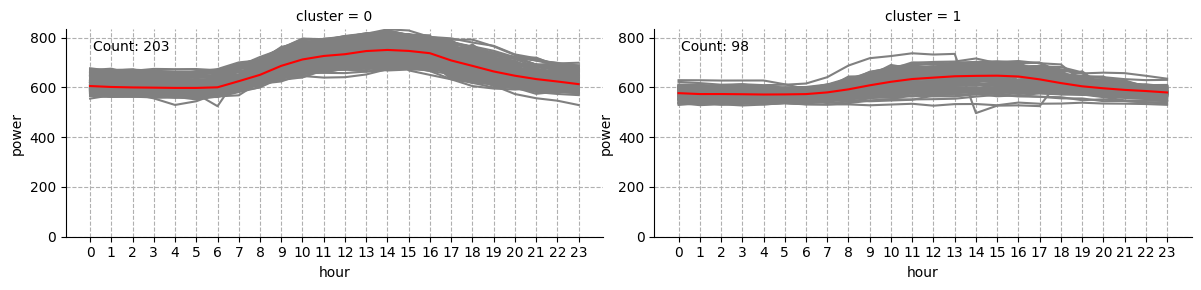

c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib\site-packages\calmap\__init__.py:202: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot("day", "week", "data").values[::-1]
c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib\site-packages\calmap\__init__.py:206: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot("day", "week", "fill").values[::-1]


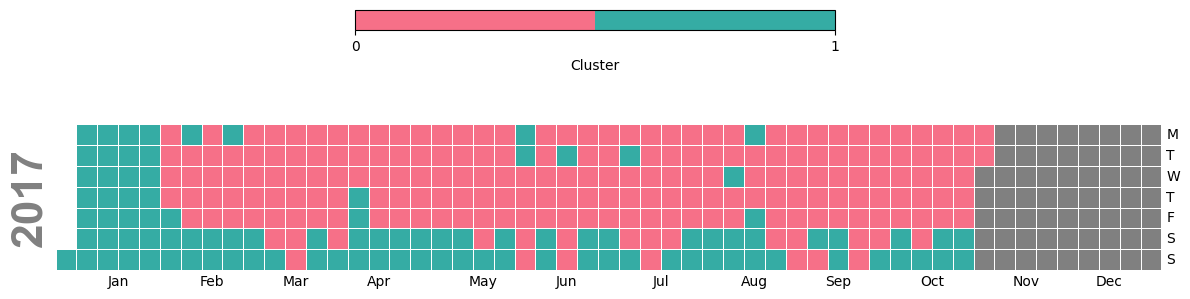

In [60]:
# Both metrics indicate 2 as the best number of cluster
K = 2
kmeans = KMeans(n_clusters=K, n_init='auto', random_state=0).fit(pv_data)
labels = kmeans.labels_
cluster_counts = np.unique(labels, return_counts=True)
cluster_counts

data_withoutNA_training['cluster'] = np.repeat(labels, 24)
plot_clustering_results(data_withoutNA_training, pv_data)

C:\Users\itgiman10\AppData\Local\Temp\ipykernel_65944\141694304.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_withoutNA_training['cluster'] = np.repeat(labels, 24)
C:\Users\itgiman10\AppData\Local\Temp\ipykernel_65944\1041416283.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = dataset.groupby(['cluster', 'hour']).mean().reset_index()


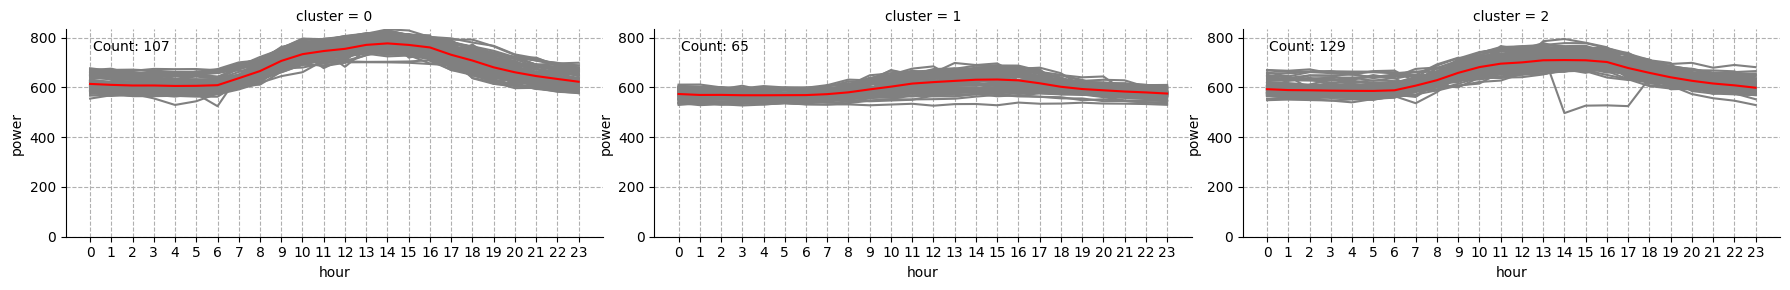

c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib\site-packages\calmap\__init__.py:202: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot("day", "week", "data").values[::-1]
c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib\site-packages\calmap\__init__.py:206: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot("day", "week", "fill").values[::-1]


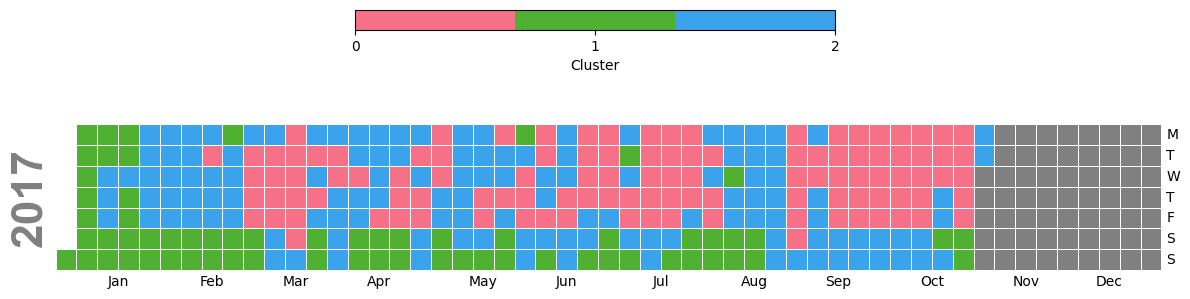

In [56]:
#TRY 3 cluster
K = 3
kmeans = KMeans(n_clusters=K, n_init='auto', random_state=0).fit(pv_data)
labels = kmeans.labels_
cluster_counts = np.unique(labels, return_counts=True)
cluster_counts

data_withoutNA_training['cluster'] = np.repeat(labels, 24)
plot_clustering_results(data_withoutNA_training, pv_data)

#### Hierarchical Clustering 

In [57]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import ParameterGrid

params = {
    "n_clusters": [2, 3, 4, 5, 6, 7, 8],
    "linkage": ["ward", "average", "complete", "single"]
}

db_df = []
sh_df = []

for config in ParameterGrid(params):
    model = AgglomerativeClustering(**config)
    model.fit(pv_data)
    db_df.append({
        'linkage': config['linkage'],
        'n_clusters': config['n_clusters'],
        'score': davies_bouldin_score(pv_data, model.labels_)
    })
    sh_df.append({
        'linkage': config['linkage'],
        'n_clusters': config['n_clusters'],
        'score': silhouette_score(pv_data, model.labels_)
    })

db_df = pd.DataFrame(db_df)
sh_df = pd.DataFrame(sh_df)

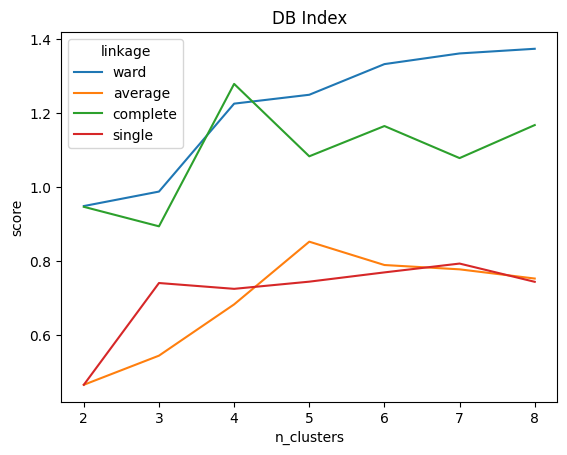

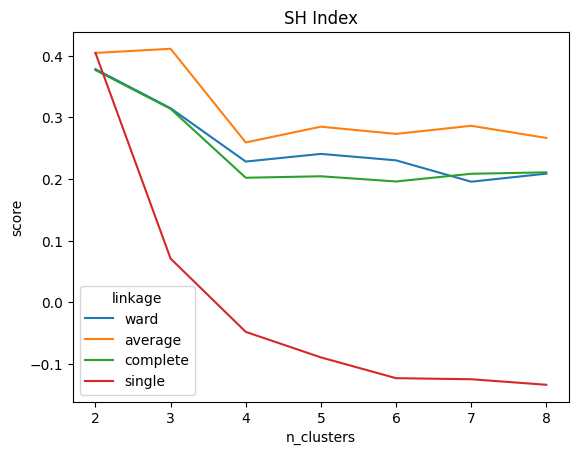

In [58]:
sns.lineplot(x="n_clusters", y="score", hue="linkage", data = db_df)
plt.title("DB Index")
plt.show()

sns.lineplot(x="n_clusters", y="score", hue="linkage", data = sh_df)
plt.title("SH Index")
plt.show()

C:\Users\itgiman10\AppData\Local\Temp\ipykernel_65944\3657832537.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_withoutNA_training['cluster'] = np.repeat(labels, 24)
C:\Users\itgiman10\AppData\Local\Temp\ipykernel_65944\1041416283.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  centroids = dataset.groupby(['cluster', 'hour']).mean().reset_index()


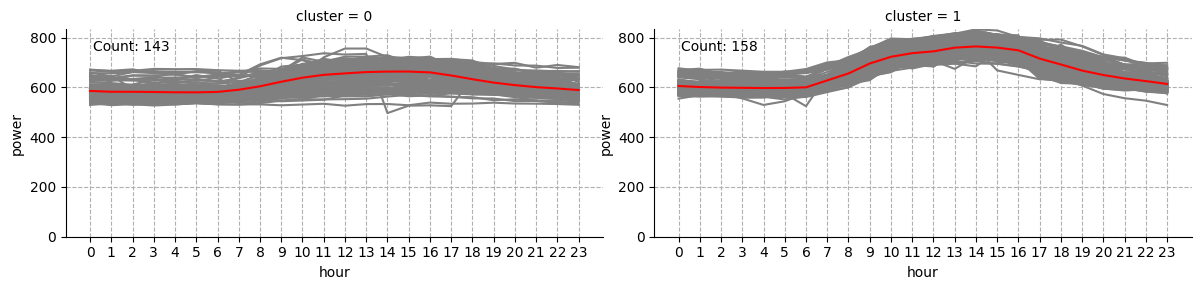

c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib\site-packages\calmap\__init__.py:202: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot("day", "week", "data").values[::-1]
c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib\site-packages\calmap\__init__.py:206: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot("day", "week", "fill").values[::-1]


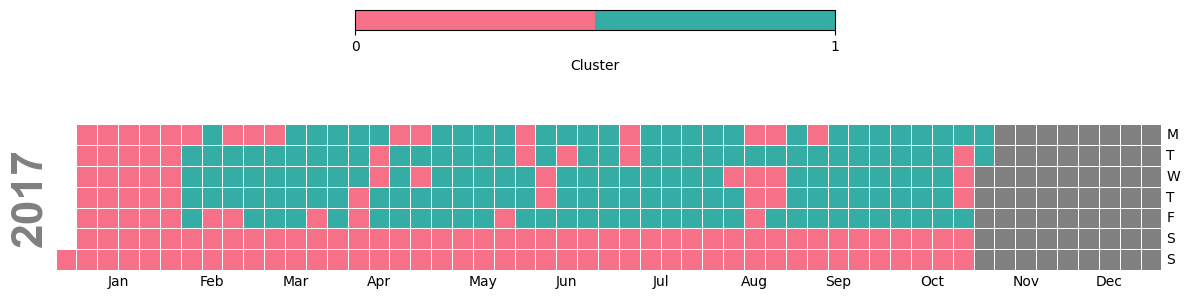

In [59]:
# Perform hierarchical clustering
K = 2
linkage_method = "ward" # "complete", "single", "average", "ward"
model = AgglomerativeClustering(distance_threshold=None, n_clusters=K, linkage=linkage_method).fit(pv_data)
labels = model.labels_

cluster_counts = np.unique(labels, return_counts=True)

data_withoutNA_training['cluster'] = np.repeat(labels, 24)
plot_clustering_results(data_withoutNA_training, pv_data)
# clustering is not exactly the same but we can still see that we find two cluster representing the days of the week and week
# 


end


### Energy benchmarking model 
#### Model training and selection

In [61]:
data_withoutNA.head()

,power,airTemperature,hour,date,dayofweek,month
timestamp,,,,,,
2017-01-01 00:00:00,537.1756,8.3,0,2017-01-01,6,1
2017-01-01 01:00:00,528.6003,10.6,1,2017-01-01,6,1
2017-01-01 02:00:00,532.4253,11.1,2,2017-01-01,6,1
2017-01-01 03:00:00,535.8997,11.1,3,2017-01-01,6,1
2017-01-01 04:00:00,531.9250,10.6,4,2017-01-01,6,1


In [114]:
# Train-test split

train = data_withoutNA["2017-01-01":"2017-10-31"]
test = data_withoutNA["2017-11-01":"2017-12-31"]

X_train = train.drop("power", axis=1)
y_train = train["power"]
X_test = test.drop("power", axis=1)
y_test = test["power"]

#X_train.reset_index(inplace=True)
#y_train.reset_index(inplace=True)
#X_test.reset_index(inplace=True)
#y_test.reset_index(inplace=True)


In [112]:
# Model definition
model = RandomForestRegressor()  # You can replace this with other models from scikit-learn

In [65]:
X_train.head()

,airTemperature,hour,date,dayofweek,month
timestamp,,,,,
2017-01-01 00:00:00,8.3,0,2017-01-01,6,1
2017-01-01 01:00:00,10.6,1,2017-01-01,6,1
2017-01-01 02:00:00,11.1,2,2017-01-01,6,1
2017-01-01 03:00:00,11.1,3,2017-01-01,6,1
2017-01-01 04:00:00,10.6,4,2017-01-01,6,1


In [66]:
y_train.head()

timestamp
2017-01-01 00:00:00    537.1756
2017-01-01 01:00:00    528.6003
2017-01-01 02:00:00    532.4253
2017-01-01 03:00:00    535.8997
2017-01-01 04:00:00    531.9250
Name: power, dtype: float64

In [115]:
X_train.drop("date",axis=1,inplace=True)
X_test.drop("date",axis=1,inplace=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#### Performance evaluation

In [64]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


MAPE on training set: 1.15%
MAE on training set: 7.46
MSE on training set: 133.16
RMSE on training set: 11.54


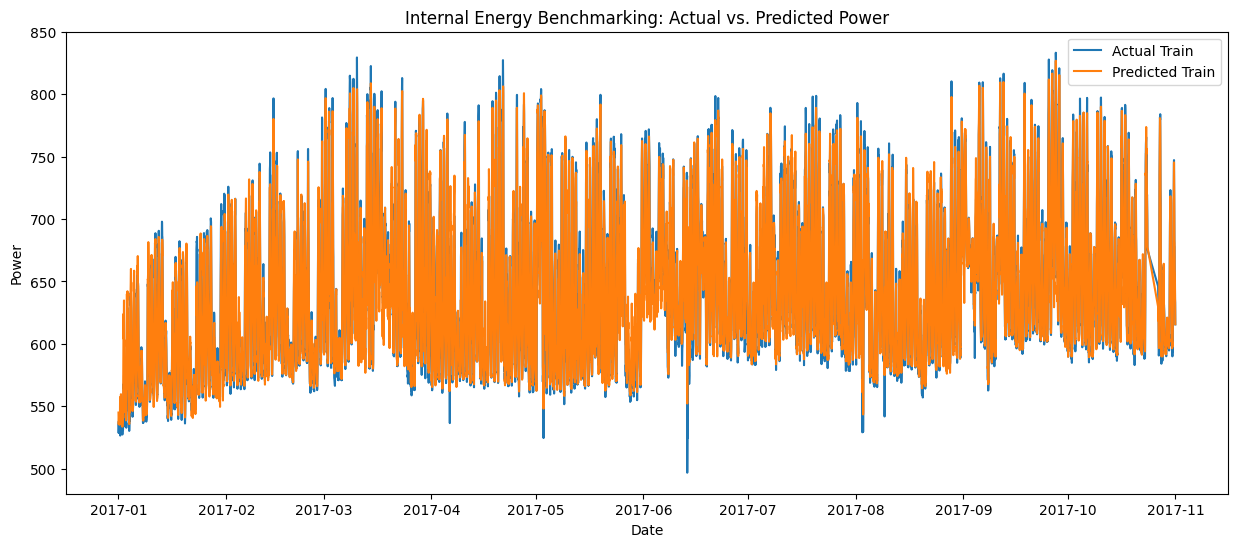

In [71]:
# Line plot with predictions and real values for both training and testing
y_train_pred = model.predict(X_train)

mape = mean_absolute_percentage_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)

print(f"MAPE on training set: {mape:.2f}%")
print(f"MAE on training set: {mae:.2f}")
print(f"MSE on training set: {mse:.2f}")
print(f"RMSE on training set: {rmse:.2f}")

plt.figure(figsize=(15, 6))
plt.plot(train.index, y_train, label="Actual Train")
plt.plot(train.index, y_train_pred, label="Predicted Train")
plt.xlabel("Date")
plt.ylabel("Power")
plt.title("Internal Energy Benchmarking: Actual vs. Predicted Power")
plt.legend()
plt.show()

MAPE: 4.98%
MAE: 30.00
MSE: 1932.55
RMSE: 43.96


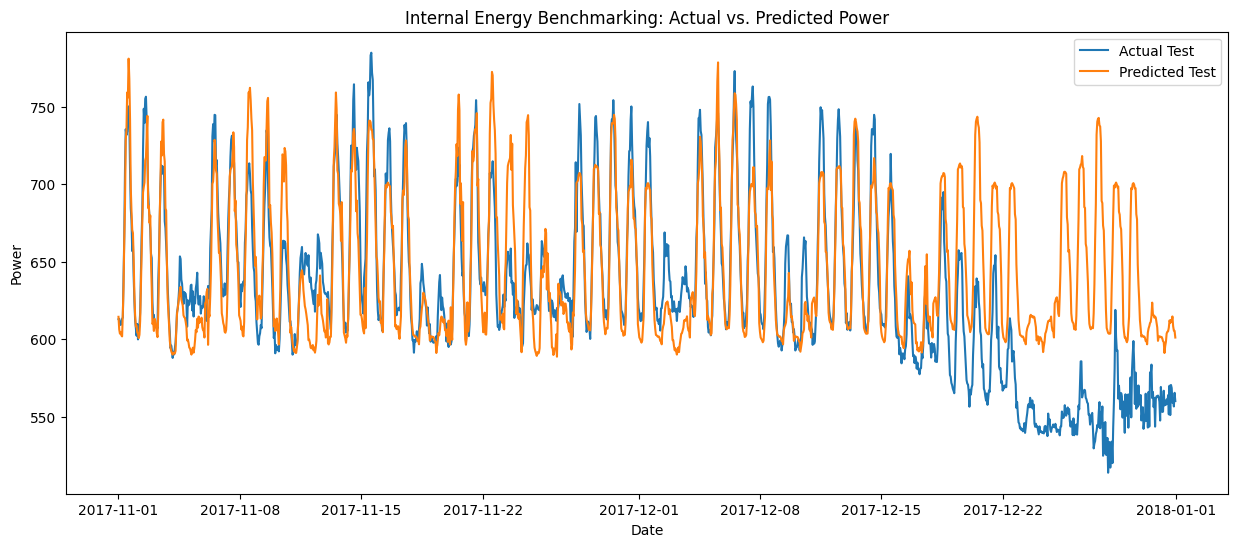

In [72]:
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

plt.figure(figsize=(15, 6))
plt.plot(test.index, y_test, label="Actual Test")
plt.plot(test.index, y_pred, label="Predicted Test")
plt.xlabel("Date")
plt.ylabel("Power")
plt.title("Internal Energy Benchmarking: Actual vs. Predicted Power")
plt.legend()
plt.show()

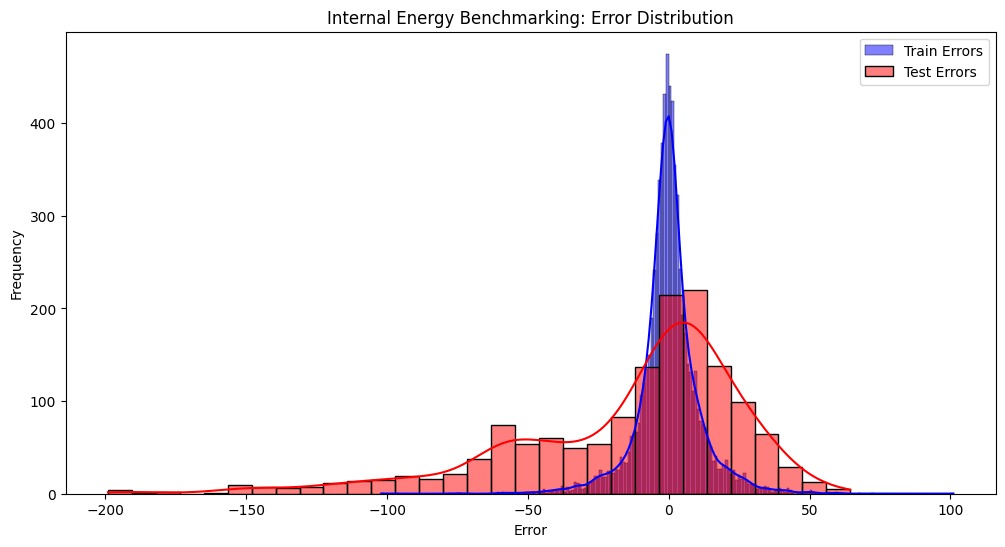

In [73]:
# Plot with the distribution of the errors for both training and testing
train_errors = y_train - y_train_pred
test_errors = y_test - y_pred

plt.figure(figsize=(12, 6))
sns.histplot(train_errors, kde=True, color="blue", label="Train Errors")
sns.histplot(test_errors, kde=True, color="red", label="Test Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Internal Energy Benchmarking: Error Distribution")
plt.legend()
plt.show()

MAPE: 5.97%
MAE: 34.16
MSE: 2002.39
RMSE: 44.75


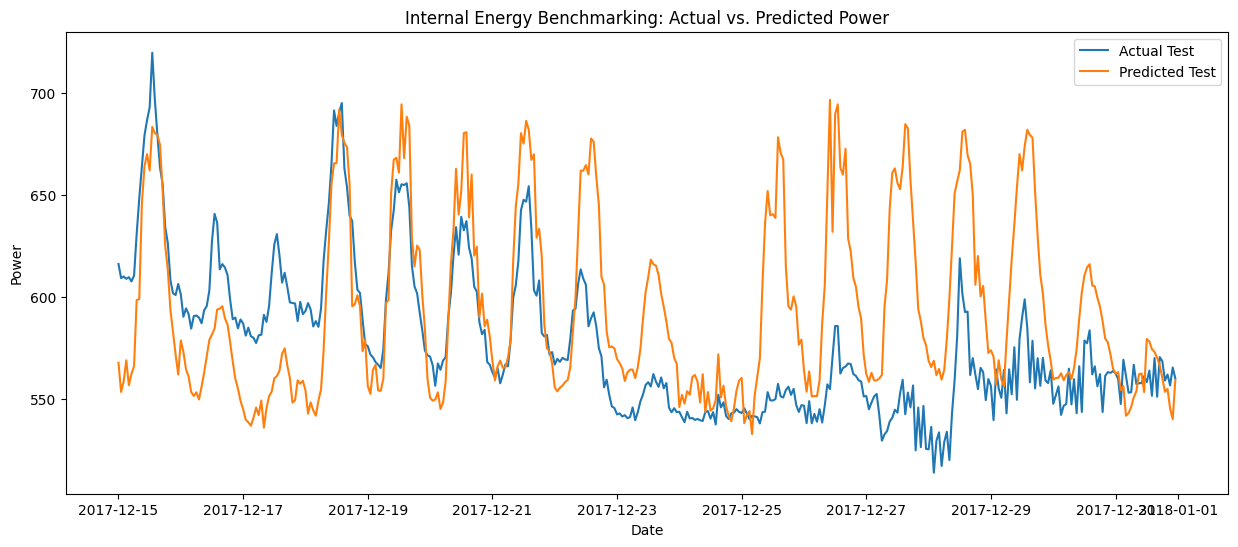

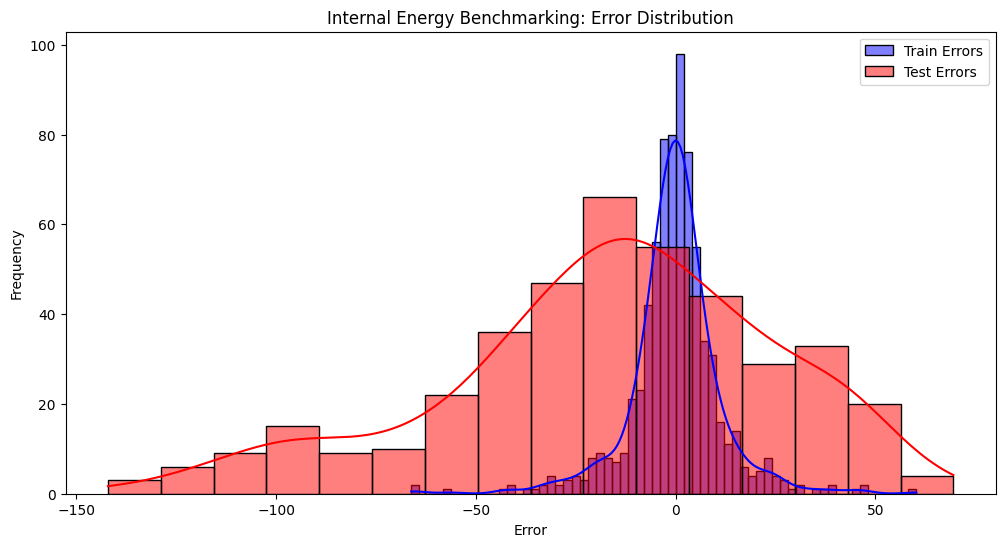

In [81]:
# Try to training the second half of december with January

X_train_jan = X_train['2017-01-01':'2017-01-31']
y_train_jan = y_train['2017-01-01':'2017-01-31']
model.fit(X_train_jan, y_train_jan)

X_test_dec = X_test['2017-12-15':'2017-12-31']
y_test_dec = y_test['2017-12-15':'2017-12-31']
y_pred_dec = model.predict(X_test_dec)

mape = mean_absolute_percentage_error(y_test_dec, y_pred_dec)
mae = mean_absolute_error(y_test_dec, y_pred_dec)
mse = mean_squared_error(y_test_dec, y_pred_dec)
rmse = np.sqrt(mse)

print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

plt.figure(figsize=(15, 6))
plt.plot(y_test_dec.index, y_test_dec, label="Actual Test")
plt.plot(y_test_dec.index, y_pred_dec, label="Predicted Test")
plt.xlabel("Date")
plt.ylabel("Power")
plt.title("Internal Energy Benchmarking: Actual vs. Predicted Power")
plt.legend()
plt.show()

# Plot with the distribution of the errors for both training and testing
y_train_pred_jan = model.predict(X_train_jan)
train_errors = y_train_jan - y_train_pred_jan
test_errors = y_test_dec - y_pred_dec

plt.figure(figsize=(12, 6))
sns.histplot(train_errors, kde=True, color="blue", label="Train Errors")
sns.histplot(test_errors, kde=True, color="red", label="Test Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Internal Energy Benchmarking: Error Distribution")
plt.legend()
plt.show()

#### Model deployment

In [92]:
y_pred[(y_pred.shape[0]-y_pred_dec.shape[0]):(y_pred.shape[0])] = y_pred_dec

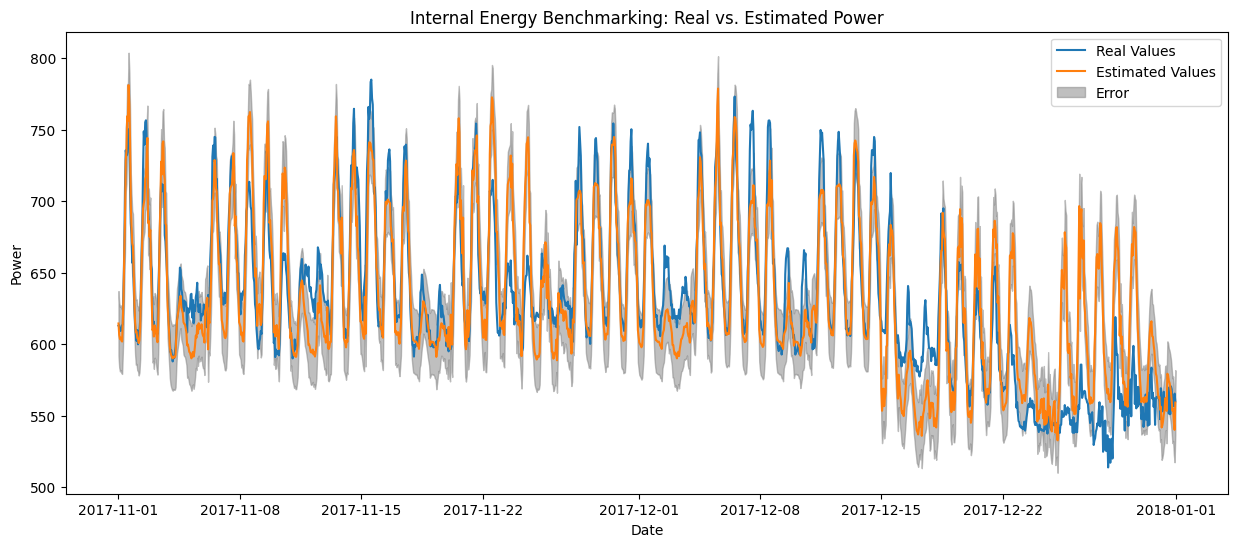

In [94]:
import scipy.stats as stats

def prediction_intervals(y_true_train, y_pred_train, y_pred_test, alpha=0.95):
    errors = y_true_train - y_pred_train
    std_errors = np.std(errors)
    z_score = stats.norm.ppf(1 - (1 - alpha) / 2)
    
    lower_bounds = y_pred_test - z_score * std_errors
    upper_bounds = y_pred_test + z_score * std_errors
    
    return lower_bounds, upper_bounds

lower_bounds, upper_bounds = prediction_intervals(y_train, y_train_pred, y_pred)


plt.figure(figsize=(15, 6))
plt.plot(test.index, y_test, label="Real Values")
plt.plot(test.index, y_pred, label="Estimated Values")
plt.fill_between(test.index, lower_bounds, upper_bounds, color="gray", alpha=0.5, label="Error")
plt.xlabel("Date")
plt.ylabel("Power")
plt.title("Internal Energy Benchmarking: Real vs. Estimated Power")
plt.legend()
plt.show()

In [95]:
test['underconsumption'] = lower_bounds - test['power']
test['underconsumption'] = test['underconsumption'].clip(lower=0)
total_underconsumption = np.round(test['underconsumption'].sum(), 1)
total_consumption = np.round(test['power'].sum(), 1)
underconsumption_percentage = np.round(total_underconsumption/total_consumption*100, 2)
print(f'Total underconsumption identified: {total_underconsumption} kWh')
print(f'Percentage of underconsumption over total: {underconsumption_percentage} %')

Total underconsumption identified: 7761.7 kWh
Percentage of underconsumption over total: 0.84 %


C:\Users\itgiman10\AppData\Local\Temp\ipykernel_65944\2461768829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['underconsumption'] = lower_bounds - test['power']
C:\Users\itgiman10\AppData\Local\Temp\ipykernel_65944\2461768829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['underconsumption'] = test['underconsumption'].clip(lower=0)


In [96]:
test['overconsumption'] = test['power'] - upper_bounds
test['overconsumption'] = test['overconsumption'].clip(lower=0)
total_overconsumption = np.round(test['overconsumption'].sum(), 1)
overconsumtion_percentage = np.round(total_overconsumption/total_consumption*100, 2)
print(f'Total underconsumption identified: {total_overconsumption} kWh')
print(f'Percentage of underconsumption over total: {overconsumtion_percentage} %')

Total underconsumption identified: 3422.9 kWh
Percentage of underconsumption over total: 0.37 %


C:\Users\itgiman10\AppData\Local\Temp\ipykernel_65944\3021277316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['overconsumption'] = test['power'] - upper_bounds
C:\Users\itgiman10\AppData\Local\Temp\ipykernel_65944\3021277316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['overconsumption'] = test['overconsumption'].clip(lower=0)


C:\Users\itgiman10\AppData\Local\Temp\ipykernel_65944\145551772.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = test.index.date
c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib\site-packages\calmap\__init__.py:202: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot("day", "week", "data").values[::-1]
c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib\site-packages\calmap\__init__.py:206: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot("day", "week", "fill").values[::-1]
C:\Users\itgiman1

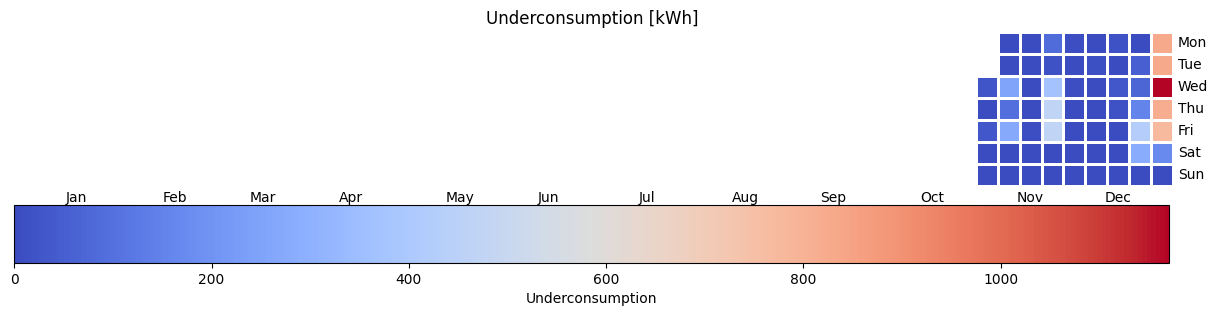

In [97]:
import calmap
import matplotlib as mpl

test['date'] = test.index.date
underconsumption_day = test.groupby('date')['underconsumption'].sum().reset_index()
underconsumption_day['date'] = pd.to_datetime(underconsumption_day['date'])
underconsumption_day = underconsumption_day.set_index('date')

plt.figure(figsize=(15, 5))
calmap.yearplot(underconsumption_day['underconsumption'], year=2017, cmap='coolwarm', fillcolor='white')
plt.title("Underconsumption [kWh]")
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=underconsumption_day['underconsumption'].min(), vmax=underconsumption_day['underconsumption'].max())
cax = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='horizontal', pad=0.05)
cax.set_label("Underconsumption")
plt.show()

c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib\site-packages\calmap\__init__.py:202: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot("day", "week", "data").values[::-1]
c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib\site-packages\calmap\__init__.py:206: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot("day", "week", "fill").values[::-1]
C:\Users\itgiman10\AppData\Local\Temp\ipykernel_65944\4294441956.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cax = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap

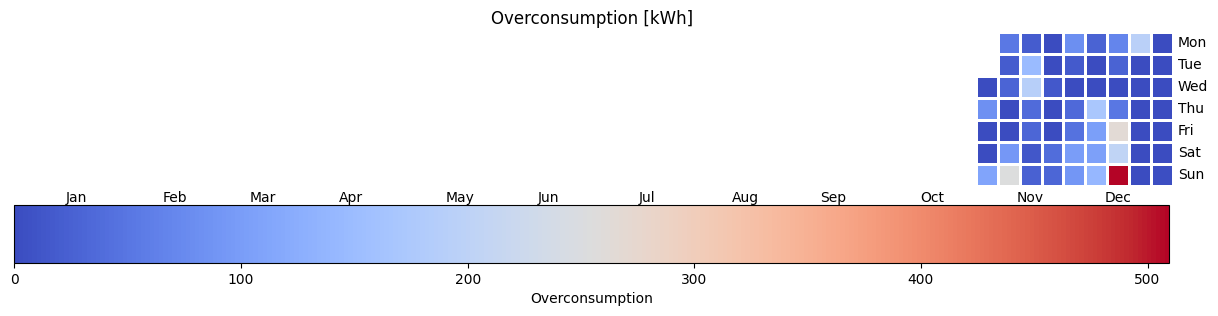

In [98]:
overconsumption_day = test.groupby('date')['overconsumption'].sum().reset_index()
overconsumption_day['date'] = pd.to_datetime(overconsumption_day['date'])
overconsumption_day = overconsumption_day.set_index('date')

plt.figure(figsize=(15, 5))
calmap.yearplot(overconsumption_day['overconsumption'], year=2017, cmap='coolwarm', fillcolor='white')
plt.title("Overconsumption [kWh]")
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=overconsumption_day['overconsumption'].min(), vmax=overconsumption_day['overconsumption'].max())
cax = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='horizontal', pad=0.05)
cax.set_label("Overconsumption")
plt.show()

C:\Users\itgiman10\AppData\Local\Temp\ipykernel_65944\1563247310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['lower_bounds'] = lower_bounds
C:\Users\itgiman10\AppData\Local\Temp\ipykernel_65944\1563247310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['upper_bounds'] = upper_bounds
C:\Users\itgiman10\AppData\Local\Temp\ipykernel_65944\1563247310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

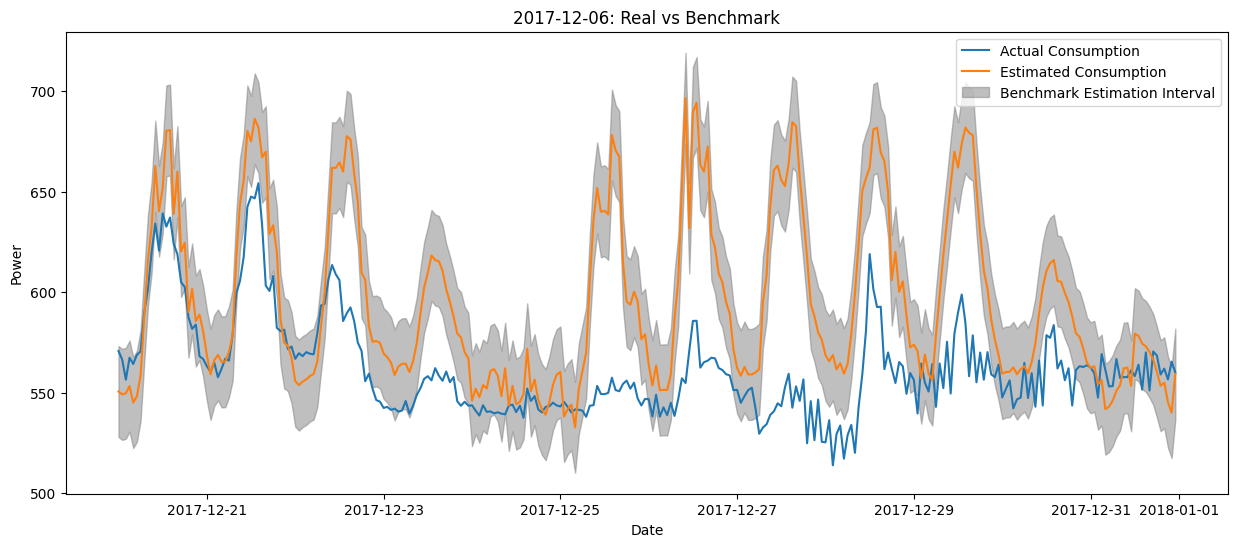

In [99]:
test['lower_bounds'] = lower_bounds
test['upper_bounds'] = upper_bounds
test['power_pred'] = y_pred

test_subset = test["2017-12-20":"2017-12-31"]

plt.figure(figsize=(15, 6))
plt.plot(test_subset.index, test_subset.power, label="Actual Consumption")
plt.plot(test_subset.index, test_subset.power_pred, label="Estimated Consumption")
plt.fill_between(test_subset.index, test_subset.lower_bounds, test_subset.upper_bounds, color="gray", alpha=0.5, 
                 label="Benchmark Estimation Interval")
plt.xlabel("Date")
plt.ylabel("Power")
plt.title("2017-12-06: Real vs Benchmark")
plt.legend()
plt.show()

#### Try a new method

In [119]:
from sklearn.neural_network import MLPRegressor #Neural network models (supervised)

train = data_withoutNA["2017-01-01":"2017-10-31"]
test = data_withoutNA["2017-11-01":"2017-12-31"]

X_train = train.drop("power", axis=1)
y_train = train["power"]
X_test = test.drop("power", axis=1)
y_test = test["power"]

X_train.drop("date",axis=1,inplace=True)
X_test.drop("date",axis=1,inplace=True)

model = MLPRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MAPE on training set: 5.44%
MAE on training set: 35.22
MSE on training set: 2039.25
RMSE on training set: 45.16


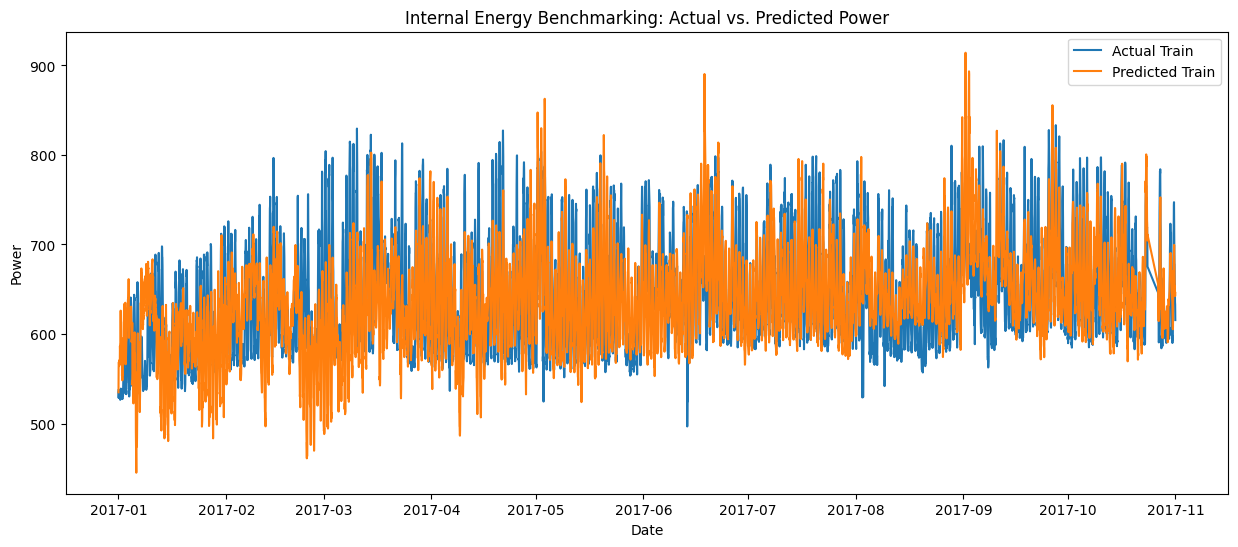

In [120]:
# Line plot with predictions and real values for both training and testing
y_train_pred = model.predict(X_train)

mape = mean_absolute_percentage_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)

print(f"MAPE on training set: {mape:.2f}%")
print(f"MAE on training set: {mae:.2f}")
print(f"MSE on training set: {mse:.2f}")
print(f"RMSE on training set: {rmse:.2f}")

plt.figure(figsize=(15, 6))
plt.plot(train.index, y_train, label="Actual Train")
plt.plot(train.index, y_train_pred, label="Predicted Train")
plt.xlabel("Date")
plt.ylabel("Power")
plt.title("Internal Energy Benchmarking: Actual vs. Predicted Power")
plt.legend()
plt.show()

MAPE: 5.86%
MAE: 36.01
MSE: 2082.70
RMSE: 45.64


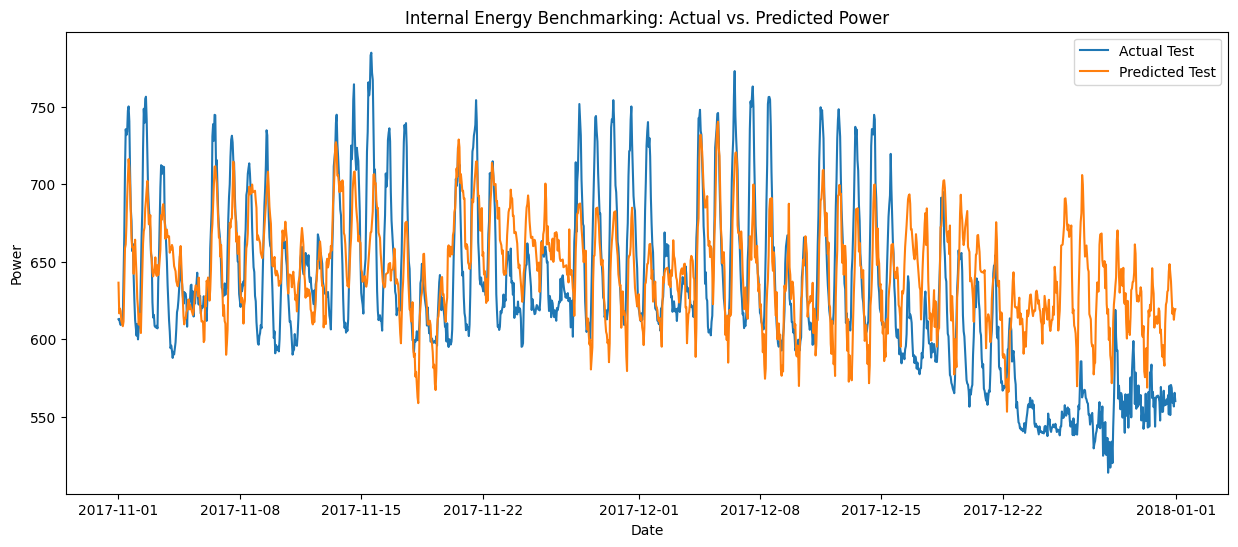

In [121]:
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

plt.figure(figsize=(15, 6))
plt.plot(test.index, y_test, label="Actual Test")
plt.plot(test.index, y_pred, label="Predicted Test")
plt.xlabel("Date")
plt.ylabel("Power")
plt.title("Internal Energy Benchmarking: Actual vs. Predicted Power")
plt.legend()
plt.show()

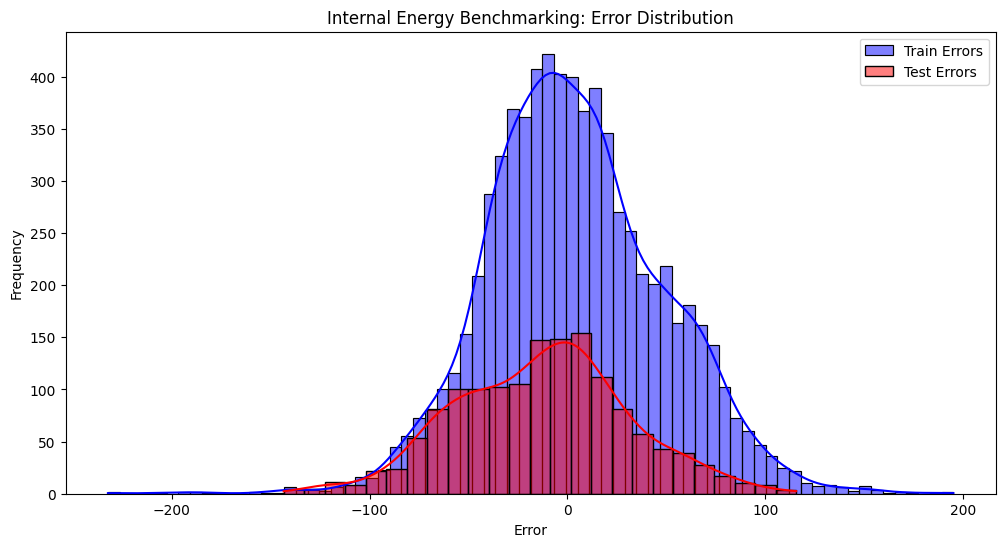

In [122]:
# Plot with the distribution of the errors for both training and testing
train_errors = y_train - y_train_pred
test_errors = y_test - y_pred

plt.figure(figsize=(12, 6))
sns.histplot(train_errors, kde=True, color="blue", label="Train Errors")
sns.histplot(test_errors, kde=True, color="red", label="Test Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Internal Energy Benchmarking: Error Distribution")
plt.legend()
plt.show()